In [1]:
import torch
import os
import matplotlib.pyplot as plt
from models.dense_baseline import get_baseline
from models.moe_model import MoEModel
from train import train_baseline, train_moe
from utils.data_loader import get_dataloaders
from utils.visualization import (
    HistoryLogger, 
    plot_multimodel_learning_curves, 
    plot_expert_utilization,
    plot_expert_utilization_histogram,
    plot_expert_counts_evolution,
    plot_expert_loss_history, 
    plot_expert_heatmap_from_history,
    compare_params_vs_performance,
    count_total_params,
    count_active_params_moe
)

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data
batch_size = 128
train_loader, val_loader, test_loader, num_classes, img_size = get_dataloaders(batch_size=batch_size)

# Global Settings
DEFAULT_EPOCHS = 5
SAVE_DIR = './experiment_results'
os.makedirs(SAVE_DIR, exist_ok=True)

/home/arthur/miniconda3/envs/ML/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
Loaded CIFAR-10: 45000 train, 5000 val, 10000 test images.


# 1. Train Models

## 1.1 Dense Baselines
We train three baselines to control for parameter count and FLOPs.
*   **Baseline (x1.0):** Matches the *active* parameters of a 4-expert MoE (Approx).
*   **Baseline (x2.0):** Intermediate size.
*   **Baseline (x3.0):** Matches the *total* parameters of a 4-expert MoE (Approx).

In [2]:
baseline_models = {}
baseline_histories = {}

# Define configs
baseline_configs = [
    {'width': 1.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 2.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 3.0, 'epochs': DEFAULT_EPOCHS}
]

for cfg in baseline_configs:
    w = cfg['width']
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    
    print(f"\n=== Training Baseline (Width x{w}, Epochs={epochs}) ===")
    model = get_baseline(input_shape=img_size, num_classes=num_classes, width_multiplier=w).to(device)
    
    save_path = os.path.join(SAVE_DIR, f'baseline_w{w}.pth')
    
    # Train
    train_baseline(model, train_loader, val_loader, test_loader, epochs, device, save_path)
    
    # Store for analysis
    baseline_models[f'Baseline_x{w}'] = model
    baseline_histories[f'Baseline_x{w}'] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training Baseline (Width x1.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 73.70it/s, loss=1.65, acc=39.7]


Epoch 1: Train Acc: 39.73%, Val Acc: 52.70%, Val Loss: 1.3390, Test Acc: 53.64%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.99it/s, loss=1.18, acc=58.1]


Epoch 2: Train Acc: 58.09%, Val Acc: 56.36%, Val Loss: 1.1988, Test Acc: 58.67%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.63it/s, loss=0.986, acc=65.2]


Epoch 3: Train Acc: 65.18%, Val Acc: 65.62%, Val Loss: 0.9899, Test Acc: 66.92%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.28it/s, loss=0.832, acc=70.9]


Epoch 4: Train Acc: 70.90%, Val Acc: 69.14%, Val Loss: 0.8794, Test Acc: 70.97%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.44it/s, loss=0.721, acc=74.6]


Epoch 5: Train Acc: 74.64%, Val Acc: 75.14%, Val Loss: 0.7254, Test Acc: 76.24%
Training finished. Final Test Accuracy: 76.24%

=== Training Baseline (Width x2.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.32it/s, loss=1.94, acc=26.8]


Epoch 1: Train Acc: 26.76%, Val Acc: 35.58%, Val Loss: 1.7943, Test Acc: 36.90%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.25it/s, loss=1.39, acc=49.2]


Epoch 2: Train Acc: 49.25%, Val Acc: 56.62%, Val Loss: 1.2220, Test Acc: 58.22%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.62it/s, loss=1.06, acc=62.1]


Epoch 3: Train Acc: 62.05%, Val Acc: 60.04%, Val Loss: 1.1653, Test Acc: 62.03%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.37it/s, loss=0.858, acc=69.6]


Epoch 4: Train Acc: 69.56%, Val Acc: 71.04%, Val Loss: 0.8582, Test Acc: 71.87%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.98it/s, loss=0.719, acc=74.8]


Epoch 5: Train Acc: 74.79%, Val Acc: 74.96%, Val Loss: 0.7340, Test Acc: 75.34%
Training finished. Final Test Accuracy: 75.34%

=== Training Baseline (Width x3.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 54.02it/s, loss=2.1, acc=20.9] 


Epoch 1: Train Acc: 20.90%, Val Acc: 25.00%, Val Loss: 1.9810, Test Acc: 26.13%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 54.06it/s, loss=1.59, acc=40.7]


Epoch 2: Train Acc: 40.72%, Val Acc: 48.74%, Val Loss: 1.4089, Test Acc: 51.89%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 54.07it/s, loss=1.17, acc=58]  


Epoch 3: Train Acc: 57.97%, Val Acc: 61.44%, Val Loss: 1.1054, Test Acc: 63.60%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.10it/s, loss=0.916, acc=67.5]


Epoch 4: Train Acc: 67.50%, Val Acc: 69.86%, Val Loss: 0.8671, Test Acc: 71.72%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.48it/s, loss=0.75, acc=73.9] 


Epoch 5: Train Acc: 73.87%, Val Acc: 74.30%, Val Loss: 0.7445, Test Acc: 75.76%
Training finished. Final Test Accuracy: 75.76%


## 1.2 MoE Models
We vary `top_k`, `num_experts`, and `aux_weight` (load balancing regularization).

*   **MoE 4 Exp, Top-1, Aux 0.0:** Control (No balancing).
*   **MoE 4 Exp, Top-1, Aux 3.0:** Standard balanced.
*   **MoE 4 Exp, Top-2, Aux 3.0:** Routing to multiple experts.
*   **MoE 4 Exp, Top-2, Aux 6.0:** High regularization.
*   **MoE 8 Exp, Top-2, Aux 8.0:** Scaling up experts.

In [ ]:
moe_configs = [
    {'name': 'MoE_4E_Top1_Aux0.0', 'experts': 4, 'topk': 1, 'aux': 0.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top1_Aux3.0', 'experts': 4, 'topk': 1, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*3},
    {'name': 'MoE_4E_Top2_Aux3.0', 'experts': 4, 'topk': 2, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*3},
    {'name': 'MoE_4E_Top2_Aux6.0', 'experts': 4, 'topk': 2, 'aux': 6.0, 'epochs': DEFAULT_EPOCHS*3},
    {'name': 'MoE_8E_Top2_Aux10.0', 'experts': 8, 'topk': 2, 'aux': 10.0, 'epochs': DEFAULT_EPOCHS*5},
]

moe_models = {}
moe_histories = {}

for cfg in moe_configs:
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    print(f"\n=== Training {cfg['name']} (Epochs={epochs}) ===")
    model = MoEModel(num_experts=cfg['experts'], num_classes=num_classes, 
                     input_channels=img_size[0], top_k=cfg['topk']).to(device)
    
    save_path = os.path.join(SAVE_DIR, f"{cfg['name']}.pth")
    
    train_moe(model, train_loader, val_loader, test_loader, epochs, device, save_path, aux_weight=cfg['aux'])
    
    moe_models[cfg['name']] = model
    moe_histories[cfg['name']] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training MoE_4E_Top1_Aux0.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=0.0, Top-K=1


Epoch 1/20: 100%|██████████| 352/352 [00:05<00:00, 70.10it/s, loss=1.68, acc=38.3]


Epoch 1: Train: 38.34% | Val: 50.90% | Test: 52.97%
   Usage: [E0:1.7% | E1:1.0% | E2:96.7% | E3:0.6%]


Epoch 2/20: 100%|██████████| 352/352 [00:04<00:00, 70.82it/s, loss=1.22, acc=56.4]


Epoch 2: Train: 56.39% | Val: 56.28% | Test: 59.00%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 3/20: 100%|██████████| 352/352 [00:04<00:00, 74.43it/s, loss=1.05, acc=63]  


Epoch 3: Train: 63.04% | Val: 63.40% | Test: 65.10%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 4/20: 100%|██████████| 352/352 [00:04<00:00, 72.36it/s, loss=0.941, acc=67]  


Epoch 4: Train: 66.96% | Val: 66.28% | Test: 67.85%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 5/20: 100%|██████████| 352/352 [00:04<00:00, 73.38it/s, loss=0.88, acc=69.3] 


Epoch 5: Train: 69.34% | Val: 62.84% | Test: 64.80%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 6/20: 100%|██████████| 352/352 [00:04<00:00, 73.91it/s, loss=0.838, acc=71]  


Epoch 6: Train: 70.98% | Val: 62.04% | Test: 64.71%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 7/20: 100%|██████████| 352/352 [00:04<00:00, 74.70it/s, loss=0.779, acc=72.9]


Epoch 7: Train: 72.89% | Val: 66.30% | Test: 67.56%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 8/20: 100%|██████████| 352/352 [00:04<00:00, 70.62it/s, loss=0.739, acc=74.1]


Epoch 8: Train: 74.12% | Val: 74.26% | Test: 75.41%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 9/20: 100%|██████████| 352/352 [00:04<00:00, 73.79it/s, loss=0.695, acc=75.9]


Epoch 9: Train: 75.94% | Val: 74.50% | Test: 76.27%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 10/20: 100%|██████████| 352/352 [00:04<00:00, 74.84it/s, loss=0.651, acc=77.2]


Epoch 10: Train: 77.24% | Val: 75.32% | Test: 76.11%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 11/20: 100%|██████████| 352/352 [00:04<00:00, 73.66it/s, loss=0.619, acc=78.4]


Epoch 11: Train: 78.43% | Val: 78.70% | Test: 80.40%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 12/20: 100%|██████████| 352/352 [00:04<00:00, 73.94it/s, loss=0.579, acc=80.1]


Epoch 12: Train: 80.14% | Val: 76.94% | Test: 78.34%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 13/20: 100%|██████████| 352/352 [00:04<00:00, 72.85it/s, loss=0.548, acc=81]  


Epoch 13: Train: 80.98% | Val: 78.86% | Test: 80.24%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 14/20: 100%|██████████| 352/352 [00:04<00:00, 73.08it/s, loss=0.512, acc=82.2]


Epoch 14: Train: 82.18% | Val: 78.94% | Test: 79.60%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 15/20: 100%|██████████| 352/352 [00:04<00:00, 74.43it/s, loss=0.474, acc=83.6]


Epoch 15: Train: 83.59% | Val: 81.04% | Test: 81.81%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 16/20: 100%|██████████| 352/352 [00:04<00:00, 72.77it/s, loss=0.441, acc=84.8]


Epoch 16: Train: 84.76% | Val: 83.32% | Test: 83.32%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 17/20: 100%|██████████| 352/352 [00:04<00:00, 73.40it/s, loss=0.41, acc=85.8] 


Epoch 17: Train: 85.82% | Val: 83.48% | Test: 83.71%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 18/20: 100%|██████████| 352/352 [00:04<00:00, 73.61it/s, loss=0.387, acc=86.6]


Epoch 18: Train: 86.56% | Val: 84.16% | Test: 84.30%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 19/20: 100%|██████████| 352/352 [00:04<00:00, 74.14it/s, loss=0.369, acc=87.3]


Epoch 19: Train: 87.33% | Val: 84.60% | Test: 84.77%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 20/20: 100%|██████████| 352/352 [00:04<00:00, 73.16it/s, loss=0.359, acc=87.5]


Epoch 20: Train: 87.53% | Val: 84.62% | Test: 84.86%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]
MoE Training finished. Final Test Accuracy: 84.86%

=== Training MoE_4E_Top1_Aux3.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=1


Epoch 1/20: 100%|██████████| 352/352 [00:04<00:00, 71.38it/s, loss=1.92, acc=32.3]


Epoch 1: Train: 32.34% | Val: 39.12% | Test: 42.21%
   Usage: [E0:34.5% | E1:33.8% | E2:30.8% | E3:0.9%]


Epoch 2/20: 100%|██████████| 352/352 [00:04<00:00, 72.84it/s, loss=1.61, acc=44.3]


Epoch 2: Train: 44.25% | Val: 50.20% | Test: 52.37%
   Usage: [E0:34.7% | E1:33.3% | E2:32.1% | E3:0.0%]


Epoch 3/20: 100%|██████████| 352/352 [00:04<00:00, 72.91it/s, loss=1.38, acc=52.7]


Epoch 3: Train: 52.66% | Val: 56.04% | Test: 57.73%
   Usage: [E0:34.1% | E1:32.4% | E2:33.6% | E3:0.0%]


Epoch 4/20: 100%|██████████| 352/352 [00:04<00:00, 71.96it/s, loss=1.26, acc=57.5]


Epoch 4: Train: 57.48% | Val: 55.46% | Test: 56.32%
   Usage: [E0:32.9% | E1:34.6% | E2:32.4% | E3:0.0%]


Epoch 5/20: 100%|██████████| 352/352 [00:05<00:00, 65.90it/s, loss=1.18, acc=60.1]


Epoch 5: Train: 60.11% | Val: 61.10% | Test: 61.91%
   Usage: [E0:33.8% | E1:34.0% | E2:32.2% | E3:0.0%]


Epoch 6/20: 100%|██████████| 352/352 [00:04<00:00, 72.11it/s, loss=1.12, acc=63]  


Epoch 6: Train: 62.96% | Val: 63.00% | Test: 65.19%
   Usage: [E0:32.4% | E1:33.1% | E2:34.5% | E3:0.0%]


Epoch 7/20: 100%|██████████| 352/352 [00:04<00:00, 71.43it/s, loss=1.06, acc=65.5]


Epoch 7: Train: 65.48% | Val: 63.84% | Test: 65.45%
   Usage: [E0:33.1% | E1:33.5% | E2:33.4% | E3:0.0%]


Epoch 8/20: 100%|██████████| 352/352 [00:04<00:00, 73.31it/s, loss=1.03, acc=66]  


Epoch 8: Train: 65.96% | Val: 65.14% | Test: 67.13%
   Usage: [E0:34.3% | E1:32.1% | E2:33.6% | E3:0.0%]


Epoch 9/20: 100%|██████████| 352/352 [00:04<00:00, 71.42it/s, loss=0.98, acc=68.2] 


Epoch 9: Train: 68.16% | Val: 66.92% | Test: 69.68%
   Usage: [E0:32.7% | E1:33.0% | E2:34.2% | E3:0.0%]


Epoch 10/20: 100%|██████████| 352/352 [00:04<00:00, 72.75it/s, loss=0.921, acc=70.4]


Epoch 10: Train: 70.36% | Val: 69.22% | Test: 70.86%
   Usage: [E0:33.3% | E1:34.1% | E2:32.6% | E3:0.0%]


Epoch 11/20: 100%|██████████| 352/352 [00:04<00:00, 71.96it/s, loss=0.886, acc=71.3]


Epoch 11: Train: 71.30% | Val: 69.10% | Test: 70.14%
   Usage: [E0:34.3% | E1:32.3% | E2:33.3% | E3:0.0%]


Epoch 12/20: 100%|██████████| 352/352 [00:04<00:00, 71.81it/s, loss=0.84, acc=73.1] 


Epoch 12: Train: 73.06% | Val: 69.62% | Test: 71.53%
   Usage: [E0:33.8% | E1:32.9% | E2:33.3% | E3:0.0%]


Epoch 13/20: 100%|██████████| 352/352 [00:04<00:00, 70.49it/s, loss=0.801, acc=74.4]


Epoch 13: Train: 74.41% | Val: 69.42% | Test: 71.90%
   Usage: [E0:33.8% | E1:32.0% | E2:34.2% | E3:0.0%]


Epoch 14/20: 100%|██████████| 352/352 [00:04<00:00, 71.91it/s, loss=0.749, acc=76]  


Epoch 14: Train: 76.02% | Val: 74.46% | Test: 75.86%
   Usage: [E0:32.7% | E1:32.8% | E2:34.5% | E3:0.0%]


Epoch 15/20: 100%|██████████| 352/352 [00:04<00:00, 71.69it/s, loss=0.716, acc=77.4]


Epoch 15: Train: 77.42% | Val: 75.44% | Test: 75.96%
   Usage: [E0:33.9% | E1:33.8% | E2:32.3% | E3:0.0%]


Epoch 16/20: 100%|██████████| 352/352 [00:04<00:00, 72.06it/s, loss=0.671, acc=79.1]


Epoch 16: Train: 79.08% | Val: 77.50% | Test: 78.00%
   Usage: [E0:33.5% | E1:32.7% | E2:33.8% | E3:0.0%]


Epoch 17/20: 100%|██████████| 352/352 [00:04<00:00, 71.81it/s, loss=0.632, acc=80.3]


Epoch 17: Train: 80.30% | Val: 77.86% | Test: 78.39%
   Usage: [E0:33.0% | E1:32.2% | E2:34.8% | E3:0.0%]


Epoch 18/20: 100%|██████████| 352/352 [00:04<00:00, 72.18it/s, loss=0.604, acc=81.3]


Epoch 18: Train: 81.34% | Val: 78.86% | Test: 80.45%
   Usage: [E0:32.0% | E1:33.2% | E2:34.9% | E3:0.0%]


Epoch 19/20: 100%|██████████| 352/352 [00:04<00:00, 72.00it/s, loss=0.579, acc=82.3]


Epoch 19: Train: 82.27% | Val: 79.98% | Test: 80.76%
   Usage: [E0:33.1% | E1:33.0% | E2:34.0% | E3:0.0%]


Epoch 20/20: 100%|██████████| 352/352 [00:04<00:00, 71.17it/s, loss=0.562, acc=82.9]


Epoch 20: Train: 82.89% | Val: 80.36% | Test: 81.10%
   Usage: [E0:32.9% | E1:33.6% | E2:33.5% | E3:0.0%]
MoE Training finished. Final Test Accuracy: 81.10%

=== Training MoE_4E_Top2_Aux3.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=2


Epoch 1/20: 100%|██████████| 352/352 [00:05<00:00, 66.68it/s, loss=1.8, acc=35.1] 


Epoch 1: Train: 35.10% | Val: 42.54% | Test: 43.27%
   Usage: [E0:27.0% | E1:25.4% | E2:22.6% | E3:25.0%]


Epoch 2/20: 100%|██████████| 352/352 [00:05<00:00, 68.67it/s, loss=1.47, acc=47]  


Epoch 2: Train: 47.01% | Val: 55.44% | Test: 56.14%
   Usage: [E0:29.5% | E1:23.2% | E2:23.3% | E3:24.0%]


Epoch 3/20: 100%|██████████| 352/352 [00:05<00:00, 66.49it/s, loss=1.28, acc=54.4]


Epoch 3: Train: 54.44% | Val: 53.40% | Test: 55.13%
   Usage: [E0:29.1% | E1:23.1% | E2:23.5% | E3:24.3%]


Epoch 4/20: 100%|██████████| 352/352 [00:05<00:00, 70.10it/s, loss=1.15, acc=59.3]


Epoch 4: Train: 59.25% | Val: 59.52% | Test: 62.56%
   Usage: [E0:28.3% | E1:23.5% | E2:23.7% | E3:24.5%]


Epoch 5/20: 100%|██████████| 352/352 [00:04<00:00, 71.43it/s, loss=1.07, acc=62.3]


Epoch 5: Train: 62.25% | Val: 59.56% | Test: 63.70%
   Usage: [E0:28.2% | E1:23.0% | E2:23.5% | E3:25.2%]


Epoch 6/20: 100%|██████████| 352/352 [00:05<00:00, 69.15it/s, loss=1, acc=64.9]   


Epoch 6: Train: 64.88% | Val: 65.98% | Test: 68.49%
   Usage: [E0:28.4% | E1:22.9% | E2:23.4% | E3:25.4%]


Epoch 7/20: 100%|██████████| 352/352 [00:05<00:00, 69.08it/s, loss=0.953, acc=66.6]


Epoch 7: Train: 66.58% | Val: 65.74% | Test: 68.67%
   Usage: [E0:29.2% | E1:23.1% | E2:22.6% | E3:25.1%]


Epoch 8/20: 100%|██████████| 352/352 [00:05<00:00, 69.53it/s, loss=0.915, acc=67.8]


Epoch 8: Train: 67.81% | Val: 66.60% | Test: 68.63%
   Usage: [E0:29.4% | E1:23.2% | E2:22.6% | E3:24.8%]


Epoch 9/20: 100%|██████████| 352/352 [00:05<00:00, 69.04it/s, loss=0.873, acc=70]  


Epoch 9: Train: 70.00% | Val: 68.70% | Test: 71.42%
   Usage: [E0:29.5% | E1:23.5% | E2:22.2% | E3:24.8%]


Epoch 10/20: 100%|██████████| 352/352 [00:04<00:00, 71.05it/s, loss=0.823, acc=71.1]


Epoch 10: Train: 71.13% | Val: 70.12% | Test: 71.55%
   Usage: [E0:29.8% | E1:23.7% | E2:22.4% | E3:24.2%]


Epoch 11/20: 100%|██████████| 352/352 [00:05<00:00, 70.33it/s, loss=0.78, acc=72.9] 


Epoch 11: Train: 72.94% | Val: 73.18% | Test: 73.58%
   Usage: [E0:31.2% | E1:22.6% | E2:22.5% | E3:23.8%]


Epoch 12/20: 100%|██████████| 352/352 [00:05<00:00, 69.26it/s, loss=0.742, acc=74.4]


Epoch 12: Train: 74.44% | Val: 70.64% | Test: 73.41%
   Usage: [E0:30.0% | E1:23.0% | E2:23.0% | E3:24.0%]


Epoch 13/20: 100%|██████████| 352/352 [00:05<00:00, 70.24it/s, loss=0.705, acc=75.6]


Epoch 13: Train: 75.64% | Val: 75.20% | Test: 76.72%
   Usage: [E0:30.1% | E1:22.4% | E2:22.8% | E3:24.7%]


Epoch 14/20: 100%|██████████| 352/352 [00:05<00:00, 70.17it/s, loss=0.657, acc=77.3]


Epoch 14: Train: 77.28% | Val: 75.26% | Test: 76.89%
   Usage: [E0:30.4% | E1:23.1% | E2:22.8% | E3:23.7%]


Epoch 15/20: 100%|██████████| 352/352 [00:05<00:00, 69.33it/s, loss=0.624, acc=78.4]


Epoch 15: Train: 78.41% | Val: 76.46% | Test: 78.20%
   Usage: [E0:30.0% | E1:23.5% | E2:23.1% | E3:23.4%]


Epoch 16/20: 100%|██████████| 352/352 [00:05<00:00, 68.27it/s, loss=0.581, acc=80.1]


Epoch 16: Train: 80.13% | Val: 78.36% | Test: 79.53%
   Usage: [E0:30.9% | E1:23.4% | E2:22.4% | E3:23.3%]


Epoch 17/20: 100%|██████████| 352/352 [00:05<00:00, 68.85it/s, loss=0.545, acc=81.3]


Epoch 17: Train: 81.28% | Val: 79.14% | Test: 80.20%
   Usage: [E0:30.9% | E1:23.5% | E2:22.2% | E3:23.3%]


Epoch 18/20: 100%|██████████| 352/352 [00:05<00:00, 69.81it/s, loss=0.517, acc=82.2]


Epoch 18: Train: 82.17% | Val: 80.10% | Test: 81.48%
   Usage: [E0:31.2% | E1:23.2% | E2:22.1% | E3:23.5%]


Epoch 19/20: 100%|██████████| 352/352 [00:05<00:00, 69.25it/s, loss=0.492, acc=83.3]


Epoch 19: Train: 83.28% | Val: 80.44% | Test: 81.99%
   Usage: [E0:31.1% | E1:23.4% | E2:22.1% | E3:23.4%]


Epoch 20/20: 100%|██████████| 352/352 [00:05<00:00, 68.76it/s, loss=0.477, acc=83.9]


Epoch 20: Train: 83.86% | Val: 80.34% | Test: 82.24%
   Usage: [E0:30.8% | E1:23.7% | E2:22.5% | E3:23.0%]
MoE Training finished. Final Test Accuracy: 82.24%

=== Training MoE_4E_Top2_Aux6.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=6.0, Top-K=2


Epoch 1/20: 100%|██████████| 352/352 [00:04<00:00, 71.34it/s, loss=1.89, acc=36.5]


Epoch 1: Train: 36.46% | Val: 45.10% | Test: 45.97%
   Usage: [E0:28.0% | E1:49.4% | E2:0.4% | E3:22.2%]


Epoch 2/20: 100%|██████████| 352/352 [00:04<00:00, 71.52it/s, loss=1.5, acc=47.6] 


Epoch 2: Train: 47.58% | Val: 52.10% | Test: 55.73%
   Usage: [E0:26.0% | E1:37.9% | E2:16.0% | E3:20.1%]


Epoch 3/20: 100%|██████████| 352/352 [00:05<00:00, 69.97it/s, loss=1.31, acc=53.7]


Epoch 3: Train: 53.71% | Val: 53.64% | Test: 55.06%
   Usage: [E0:24.4% | E1:31.5% | E2:24.1% | E3:20.0%]


Epoch 4/20: 100%|██████████| 352/352 [00:05<00:00, 70.25it/s, loss=1.18, acc=58.5]


Epoch 4: Train: 58.50% | Val: 58.80% | Test: 61.31%
   Usage: [E0:23.0% | E1:31.9% | E2:25.8% | E3:19.3%]


Epoch 5/20: 100%|██████████| 352/352 [00:05<00:00, 69.03it/s, loss=1.09, acc=62.1]


Epoch 5: Train: 62.15% | Val: 58.82% | Test: 62.96%
   Usage: [E0:22.5% | E1:30.7% | E2:27.3% | E3:19.5%]


Epoch 6/20: 100%|██████████| 352/352 [00:05<00:00, 69.12it/s, loss=1.03, acc=64.3]


Epoch 6: Train: 64.30% | Val: 65.34% | Test: 67.73%
   Usage: [E0:22.5% | E1:30.3% | E2:27.3% | E3:19.8%]


Epoch 7/20: 100%|██████████| 352/352 [00:05<00:00, 70.31it/s, loss=0.981, acc=66]  


Epoch 7: Train: 65.96% | Val: 65.92% | Test: 68.61%
   Usage: [E0:22.7% | E1:29.8% | E2:27.2% | E3:20.4%]


Epoch 8/20: 100%|██████████| 352/352 [00:05<00:00, 70.05it/s, loss=0.927, acc=67.7]


Epoch 8: Train: 67.72% | Val: 68.74% | Test: 70.96%
   Usage: [E0:22.1% | E1:30.0% | E2:27.5% | E3:20.3%]


Epoch 9/20: 100%|██████████| 352/352 [00:05<00:00, 69.36it/s, loss=0.879, acc=69.6]


Epoch 9: Train: 69.62% | Val: 67.62% | Test: 70.47%
   Usage: [E0:21.9% | E1:30.0% | E2:28.1% | E3:20.0%]


Epoch 10/20: 100%|██████████| 352/352 [00:05<00:00, 70.09it/s, loss=0.839, acc=71]  


Epoch 10: Train: 70.99% | Val: 70.30% | Test: 69.87%
   Usage: [E0:21.7% | E1:29.9% | E2:28.5% | E3:20.0%]


Epoch 11/20: 100%|██████████| 352/352 [00:05<00:00, 69.92it/s, loss=0.799, acc=72.2]


Epoch 11: Train: 72.25% | Val: 70.56% | Test: 73.24%
   Usage: [E0:22.3% | E1:29.5% | E2:28.3% | E3:20.0%]


Epoch 12/20: 100%|██████████| 352/352 [00:05<00:00, 70.18it/s, loss=0.763, acc=73.9]


Epoch 12: Train: 73.88% | Val: 70.78% | Test: 72.41%
   Usage: [E0:21.9% | E1:29.6% | E2:29.1% | E3:19.3%]


Epoch 13/20: 100%|██████████| 352/352 [00:04<00:00, 71.19it/s, loss=0.717, acc=75.3]


Epoch 13: Train: 75.25% | Val: 74.88% | Test: 76.10%
   Usage: [E0:21.3% | E1:29.8% | E2:29.1% | E3:19.8%]


Epoch 14/20: 100%|██████████| 352/352 [00:05<00:00, 70.07it/s, loss=0.677, acc=76.8]


Epoch 14: Train: 76.77% | Val: 76.02% | Test: 76.99%
   Usage: [E0:21.7% | E1:29.6% | E2:29.2% | E3:19.5%]


Epoch 15/20: 100%|██████████| 352/352 [00:05<00:00, 69.56it/s, loss=0.636, acc=78.1]


Epoch 15: Train: 78.06% | Val: 75.86% | Test: 76.70%
   Usage: [E0:21.6% | E1:29.4% | E2:29.8% | E3:19.2%]


Epoch 16/20: 100%|██████████| 352/352 [00:05<00:00, 69.46it/s, loss=0.594, acc=79.8]


Epoch 16: Train: 79.76% | Val: 78.84% | Test: 79.66%
   Usage: [E0:21.7% | E1:29.2% | E2:30.0% | E3:19.2%]


Epoch 17/20: 100%|██████████| 352/352 [00:05<00:00, 69.50it/s, loss=0.562, acc=80.8]


Epoch 17: Train: 80.82% | Val: 79.20% | Test: 80.52%
   Usage: [E0:21.4% | E1:29.4% | E2:30.1% | E3:19.1%]


Epoch 18/20: 100%|██████████| 352/352 [00:05<00:00, 69.72it/s, loss=0.529, acc=82.1]


Epoch 18: Train: 82.05% | Val: 79.68% | Test: 80.82%
   Usage: [E0:21.7% | E1:29.1% | E2:30.2% | E3:19.0%]


Epoch 19/20: 100%|██████████| 352/352 [00:05<00:00, 68.65it/s, loss=0.507, acc=82.8]


Epoch 19: Train: 82.83% | Val: 81.18% | Test: 81.84%
   Usage: [E0:21.3% | E1:29.3% | E2:30.1% | E3:19.2%]


Epoch 20/20: 100%|██████████| 352/352 [00:05<00:00, 69.66it/s, loss=0.497, acc=83]  


Epoch 20: Train: 83.01% | Val: 80.50% | Test: 81.86%
   Usage: [E0:21.4% | E1:29.3% | E2:30.5% | E3:18.9%]
MoE Training finished. Final Test Accuracy: 81.86%

=== Training MoE_8E_Top2_Aux10.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=10.0, Top-K=2


Epoch 1/20: 100%|██████████| 352/352 [00:07<00:00, 48.80it/s, loss=1.89, acc=33.3]


Epoch 1: Train: 33.31% | Val: 41.38% | Test: 44.55%
   Usage: [E0:3.0% | E1:14.7% | E2:14.9% | E3:14.4% | E4:12.4% | E5:17.1% | E6:7.8% | E7:15.8%]


Epoch 2/20: 100%|██████████| 352/352 [00:07<00:00, 44.93it/s, loss=1.59, acc=42.5]


Epoch 2: Train: 42.52% | Val: 48.14% | Test: 49.51%
   Usage: [E0:11.3% | E1:12.3% | E2:12.7% | E3:13.1% | E4:12.5% | E5:13.9% | E6:11.4% | E7:12.8%]


Epoch 3/20: 100%|██████████| 352/352 [00:07<00:00, 46.49it/s, loss=1.44, acc=48.6]


Epoch 3: Train: 48.65% | Val: 50.32% | Test: 51.92%
   Usage: [E0:10.5% | E1:12.2% | E2:12.6% | E3:13.2% | E4:12.8% | E5:14.0% | E6:12.2% | E7:12.6%]


Epoch 4/20: 100%|██████████| 352/352 [00:07<00:00, 44.16it/s, loss=1.33, acc=52.9]


Epoch 4: Train: 52.88% | Val: 54.38% | Test: 56.26%
   Usage: [E0:11.3% | E1:12.8% | E2:12.6% | E3:13.3% | E4:12.0% | E5:13.2% | E6:12.1% | E7:12.6%]


Epoch 5/20: 100%|██████████| 352/352 [00:07<00:00, 45.05it/s, loss=1.24, acc=56.4]


Epoch 5: Train: 56.39% | Val: 56.94% | Test: 60.31%
   Usage: [E0:11.2% | E1:13.0% | E2:12.2% | E3:12.5% | E4:12.8% | E5:14.2% | E6:11.5% | E7:12.7%]


Epoch 6/20: 100%|██████████| 352/352 [00:07<00:00, 45.04it/s, loss=1.18, acc=58.7]


Epoch 6: Train: 58.73% | Val: 59.46% | Test: 62.90%
   Usage: [E0:11.1% | E1:13.2% | E2:12.2% | E3:13.6% | E4:11.6% | E5:14.0% | E6:11.6% | E7:12.7%]


Epoch 7/20: 100%|██████████| 352/352 [00:07<00:00, 44.91it/s, loss=1.12, acc=60.8]


Epoch 7: Train: 60.85% | Val: 60.46% | Test: 62.43%
   Usage: [E0:12.3% | E1:12.4% | E2:11.7% | E3:13.0% | E4:11.2% | E5:13.8% | E6:12.8% | E7:12.9%]


Epoch 8/20: 100%|██████████| 352/352 [00:07<00:00, 44.78it/s, loss=1.07, acc=62.8]


Epoch 8: Train: 62.77% | Val: 62.92% | Test: 65.09%
   Usage: [E0:12.3% | E1:11.9% | E2:11.3% | E3:13.2% | E4:11.5% | E5:14.5% | E6:13.1% | E7:12.2%]


Epoch 9/20: 100%|██████████| 352/352 [00:07<00:00, 45.64it/s, loss=1.02, acc=64.8]


Epoch 9: Train: 64.76% | Val: 64.22% | Test: 65.57%
   Usage: [E0:12.3% | E1:11.4% | E2:11.1% | E3:14.4% | E4:10.6% | E5:14.1% | E6:13.3% | E7:12.8%]


Epoch 10/20: 100%|██████████| 352/352 [00:07<00:00, 46.08it/s, loss=0.978, acc=66.1]


Epoch 10: Train: 66.14% | Val: 65.10% | Test: 67.69%
   Usage: [E0:11.5% | E1:11.0% | E2:11.5% | E3:14.1% | E4:11.4% | E5:14.1% | E6:13.8% | E7:12.7%]


Epoch 11/20: 100%|██████████| 352/352 [00:07<00:00, 46.05it/s, loss=0.933, acc=67.7]


Epoch 11: Train: 67.66% | Val: 66.88% | Test: 68.95%
   Usage: [E0:11.6% | E1:11.0% | E2:12.1% | E3:14.5% | E4:10.9% | E5:13.5% | E6:13.8% | E7:12.6%]


Epoch 12/20: 100%|██████████| 352/352 [00:07<00:00, 45.73it/s, loss=0.886, acc=69.4]


Epoch 12: Train: 69.45% | Val: 68.44% | Test: 69.44%
   Usage: [E0:11.8% | E1:10.7% | E2:12.1% | E3:15.3% | E4:10.4% | E5:13.6% | E6:13.7% | E7:12.4%]


Epoch 13/20: 100%|██████████| 352/352 [00:07<00:00, 45.00it/s, loss=0.844, acc=70.7]


Epoch 13: Train: 70.74% | Val: 69.70% | Test: 70.92%
   Usage: [E0:12.4% | E1:11.1% | E2:11.7% | E3:15.2% | E4:11.1% | E5:13.3% | E6:12.9% | E7:12.3%]


Epoch 14/20: 100%|██████████| 352/352 [00:07<00:00, 46.09it/s, loss=0.801, acc=72.4]


Epoch 14: Train: 72.43% | Val: 71.60% | Test: 73.51%
   Usage: [E0:12.3% | E1:10.9% | E2:11.7% | E3:15.0% | E4:10.8% | E5:13.5% | E6:13.3% | E7:12.6%]


Epoch 15/20: 100%|██████████| 352/352 [00:07<00:00, 45.52it/s, loss=0.756, acc=74.1]


Epoch 15: Train: 74.08% | Val: 73.30% | Test: 73.77%
   Usage: [E0:12.2% | E1:11.0% | E2:11.8% | E3:15.6% | E4:10.6% | E5:13.4% | E6:13.1% | E7:12.3%]


Epoch 16/20: 100%|██████████| 352/352 [00:07<00:00, 45.35it/s, loss=0.72, acc=75.3] 


Epoch 16: Train: 75.30% | Val: 74.06% | Test: 75.04%
   Usage: [E0:12.2% | E1:10.6% | E2:11.7% | E3:16.0% | E4:10.3% | E5:13.0% | E6:13.5% | E7:12.7%]


Epoch 17/20: 100%|██████████| 352/352 [00:07<00:00, 44.44it/s, loss=0.677, acc=77.1]


Epoch 17: Train: 77.09% | Val: 75.58% | Test: 76.10%
   Usage: [E0:12.2% | E1:10.8% | E2:11.6% | E3:15.6% | E4:10.8% | E5:13.5% | E6:13.0% | E7:12.5%]


Epoch 18/20: 100%|██████████| 352/352 [00:07<00:00, 44.79it/s, loss=0.642, acc=78.1]


Epoch 18: Train: 78.09% | Val: 76.76% | Test: 77.61%
   Usage: [E0:12.7% | E1:10.6% | E2:11.6% | E3:15.4% | E4:10.9% | E5:13.4% | E6:13.1% | E7:12.3%]


Epoch 19/20: 100%|██████████| 352/352 [00:07<00:00, 45.32it/s, loss=0.62, acc=79]   


Epoch 19: Train: 79.03% | Val: 77.44% | Test: 78.19%
   Usage: [E0:12.8% | E1:10.3% | E2:11.4% | E3:15.7% | E4:10.9% | E5:13.1% | E6:13.2% | E7:12.5%]


Epoch 20/20: 100%|██████████| 352/352 [00:07<00:00, 45.76it/s, loss=0.606, acc=79.6]


Epoch 20: Train: 79.57% | Val: 77.68% | Test: 78.16%
   Usage: [E0:12.6% | E1:10.6% | E2:11.2% | E3:15.5% | E4:11.0% | E5:13.9% | E6:12.8% | E7:12.4%]
MoE Training finished. Final Test Accuracy: 78.16%


# 2. Global Performance Analysis

## 2.1 Training Dynamics (Accuracy & Loss)

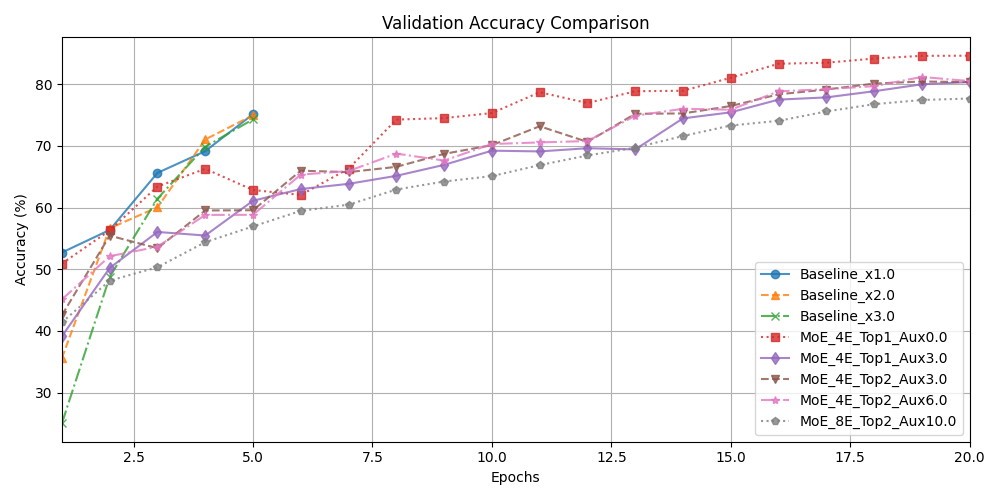

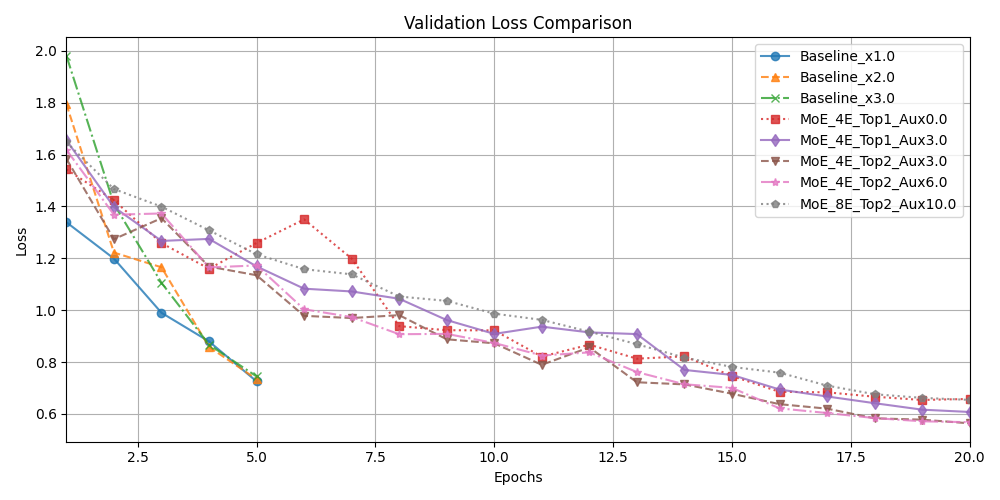

In [4]:
# Combine all histories for plotting
all_histories = {**baseline_histories, **moe_histories}

# Plot multimodel comparison
plot_multimodel_learning_curves(all_histories, SAVE_DIR)

# Display plots inline
from IPython.display import Image, display
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_accuracy.png')))
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_loss.png')))


## 2.2 Efficiency vs. Capacity
*   **Left:** Accuracy vs. Total Parameters (Storage Cost).
*   **Right:** Accuracy vs. Active Parameters (Inference Cost/Speed).

=== Accuracy vs Total Parameters (Storage) ===


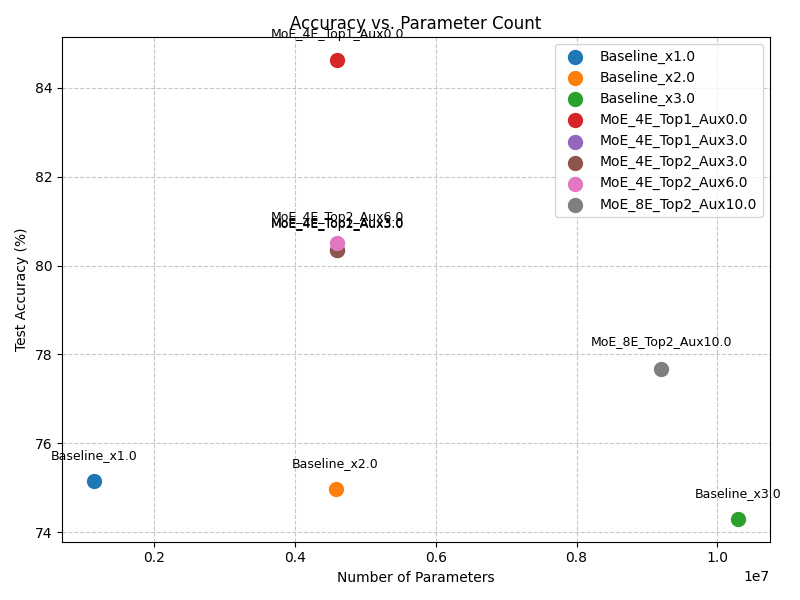


=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===


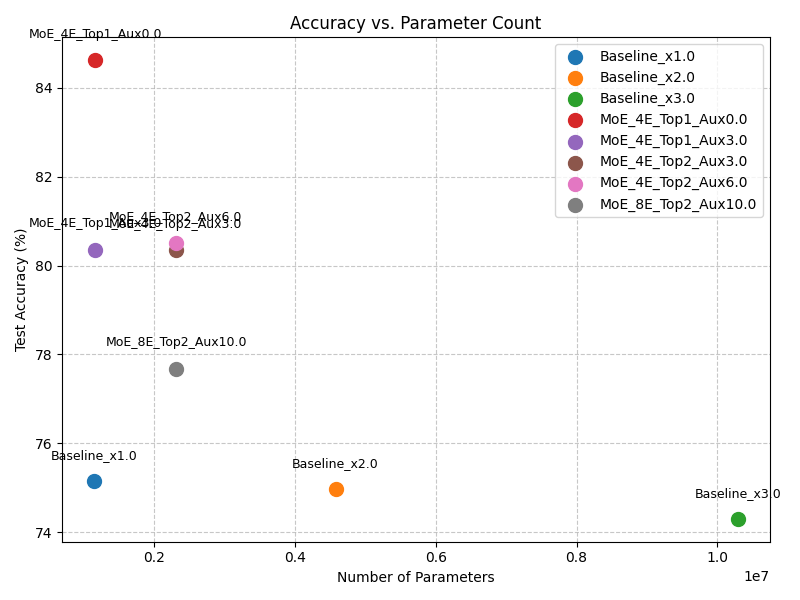

In [5]:
storage_data = [] # Accuracy vs Total Params
compute_data = [] # Accuracy vs Active Params

# Process Baselines
for name, model in baseline_models.items():
    acc = baseline_histories[name].history['val_acc'][-1]
    total_p = count_total_params(model)
    # For dense models, active = total
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': total_p, 'accuracy': acc})

# Process MoEs
for name, model in moe_models.items():
    acc = moe_histories[name].history['val_acc'][-1]
    
    total_p = count_total_params(model)
    active_p = count_active_params_moe(model)
    
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': active_p, 'accuracy': acc})

# Plot 1: Storage
print("=== Accuracy vs Total Parameters (Storage) ===")
compare_params_vs_performance(storage_data, os.path.join(SAVE_DIR, 'acc_vs_storage.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_storage.png')))

# Plot 2: Compute
print("\n=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===")
compare_params_vs_performance(compute_data, os.path.join(SAVE_DIR, 'acc_vs_compute.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_compute.png')))


# 3. Gating & Expert Analysis

We analyze how experts are utilized and how they learn.
*   **Utilization Histogram:** Did the experts handle an equal share of data?
*   **Counts Evolution:** How many samples per expert over time?
*   **Loss Evolution:** Did experts learn at the same speed?


--- Analyzing MoE_4E_Top1_Aux0.0 ---


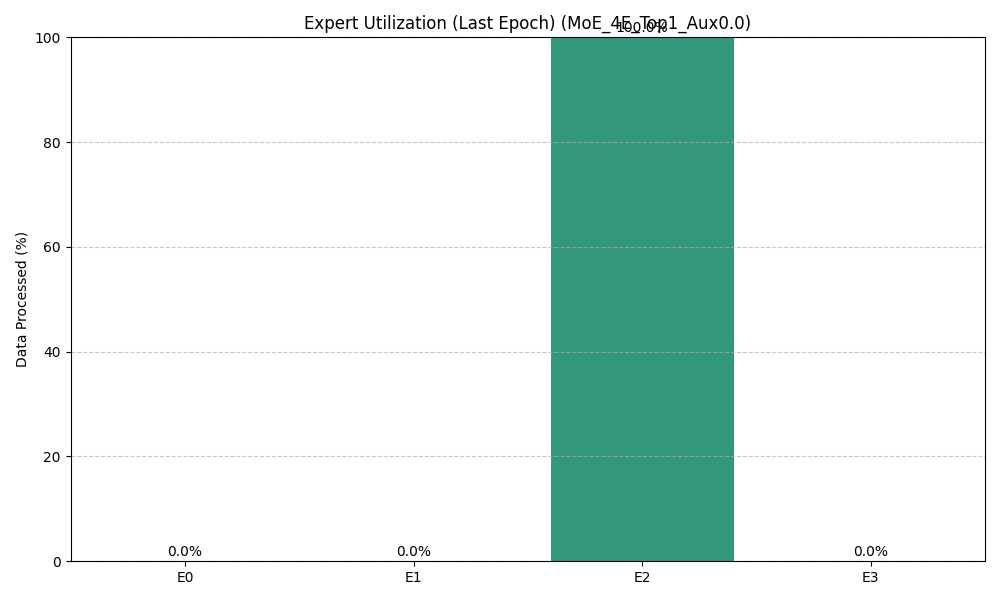

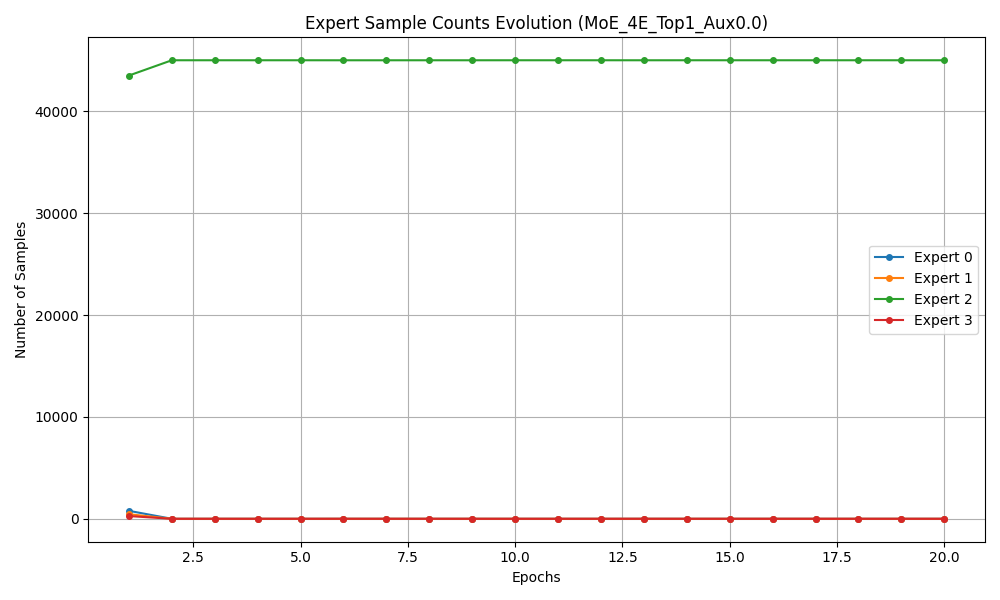

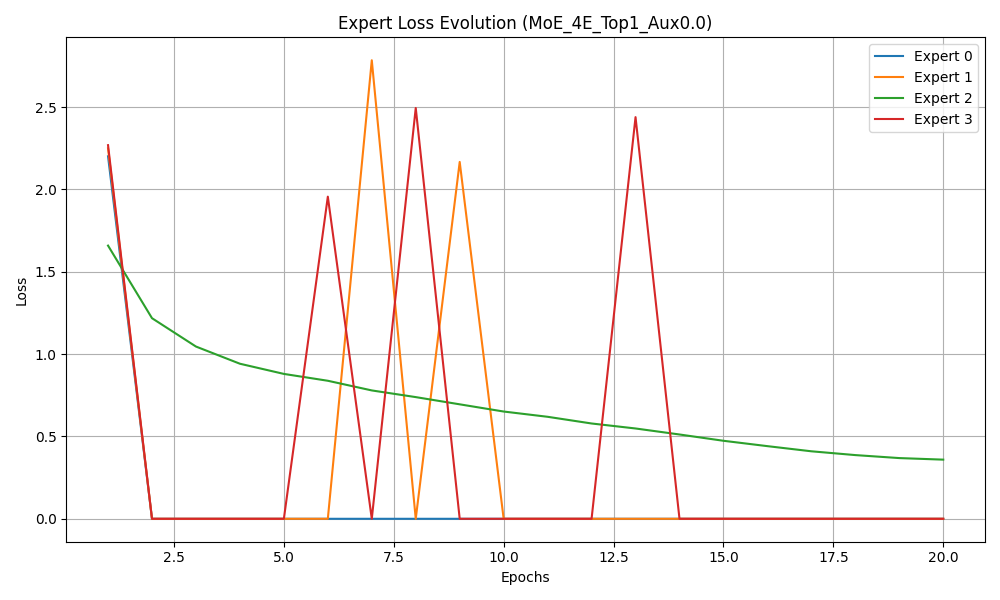


--- Analyzing MoE_4E_Top1_Aux3.0 ---


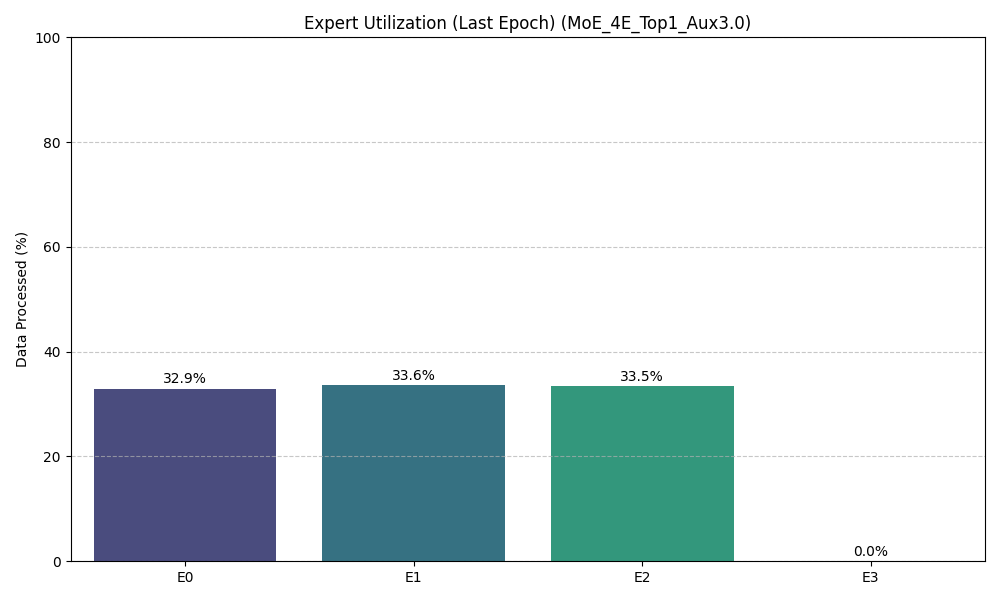

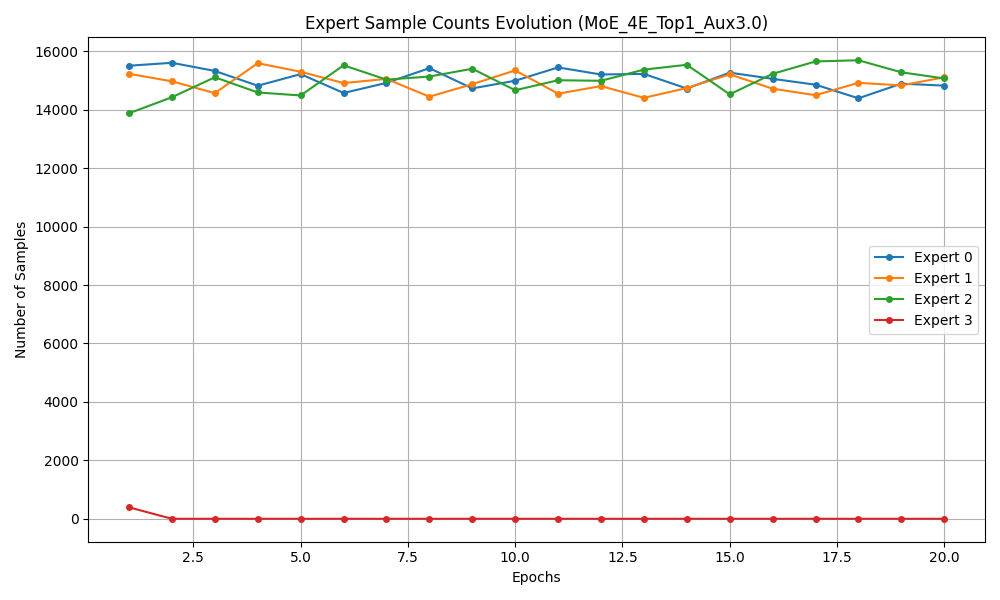

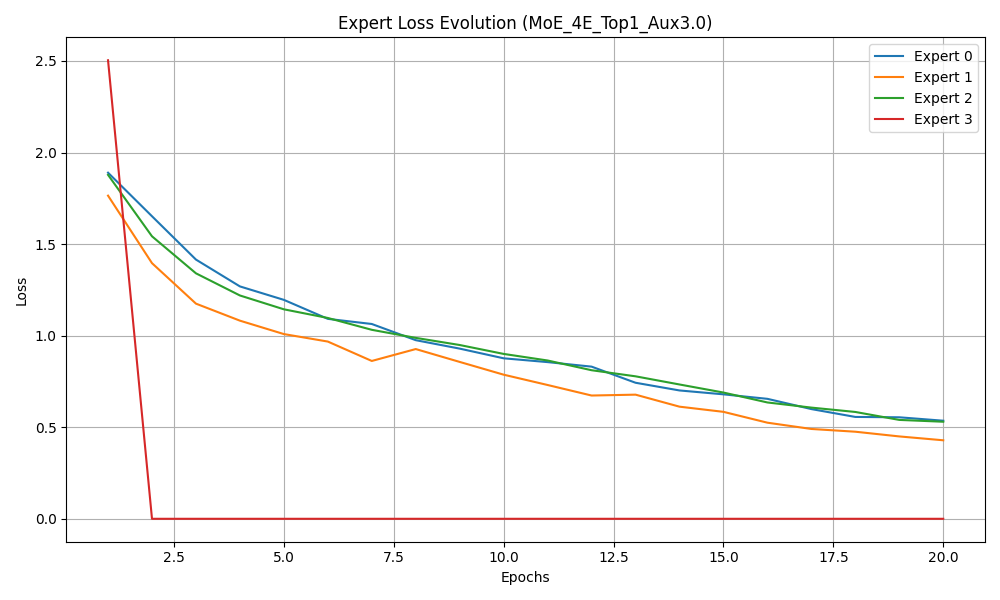


--- Analyzing MoE_4E_Top2_Aux3.0 ---


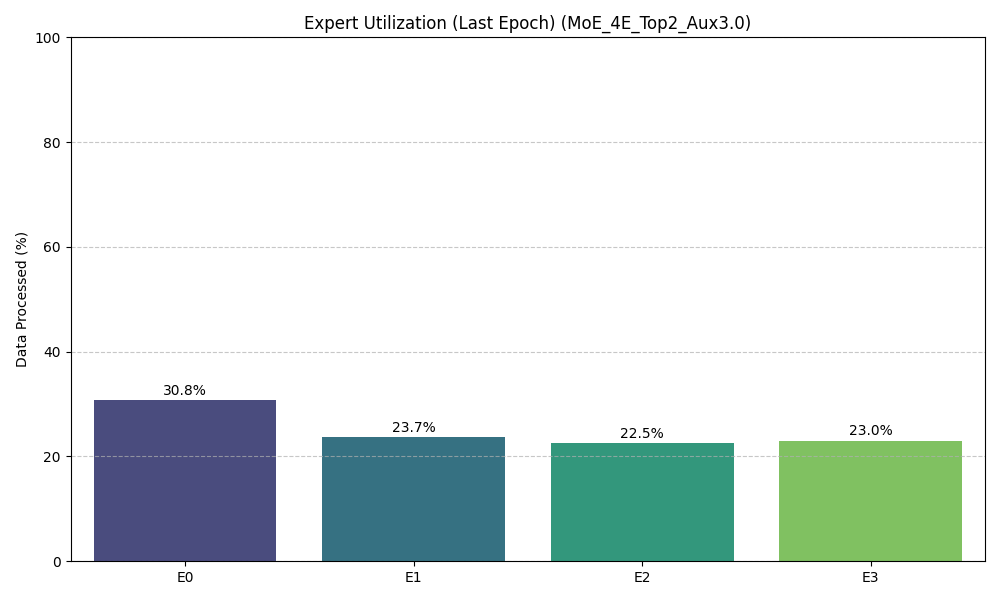

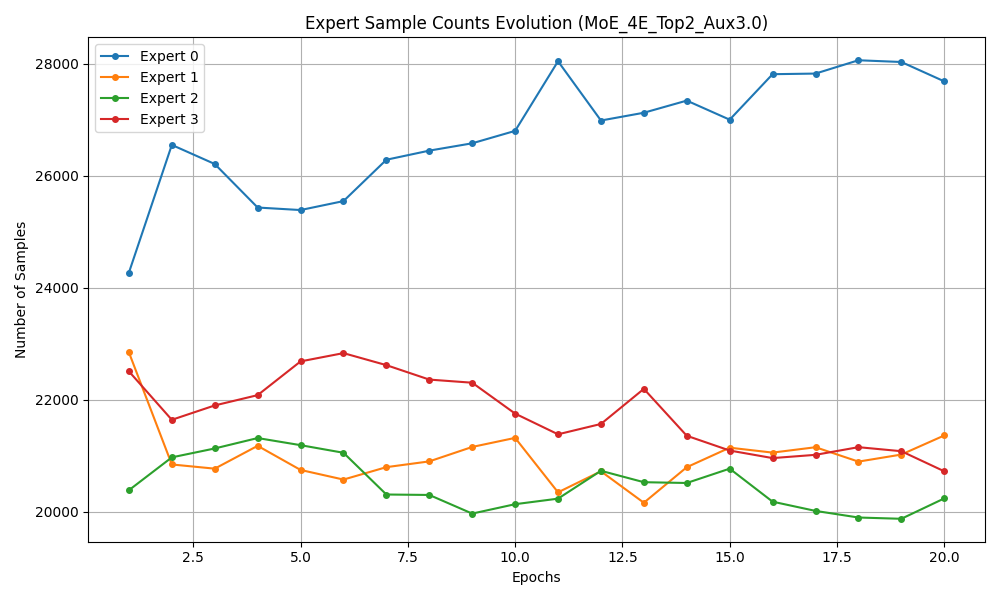

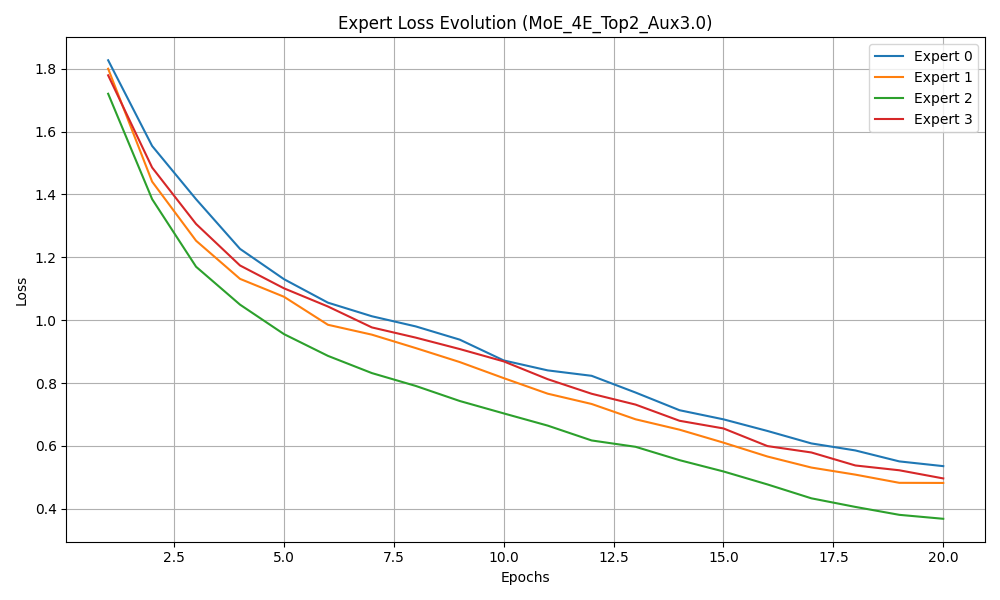


--- Analyzing MoE_4E_Top2_Aux6.0 ---


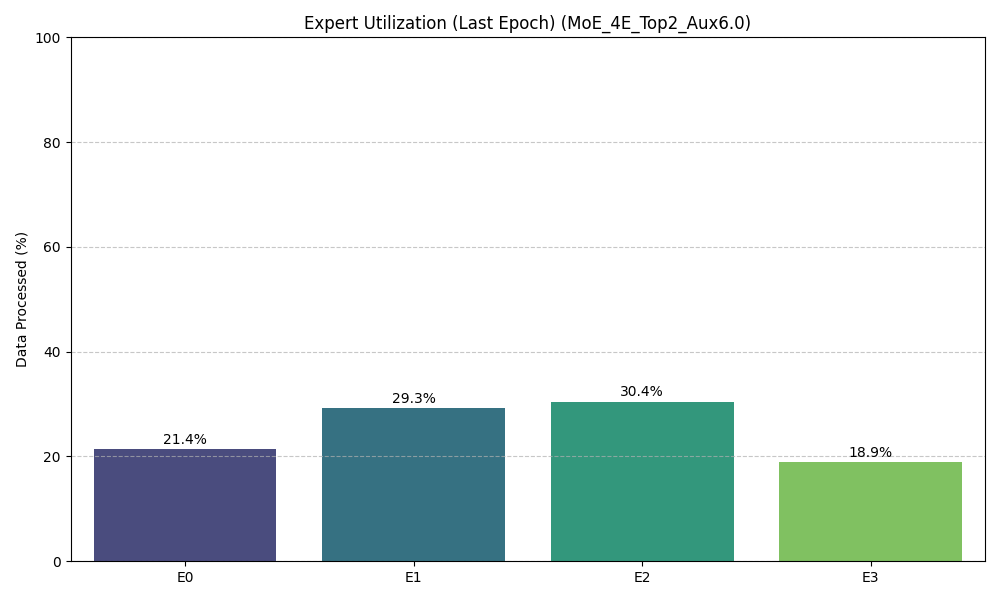

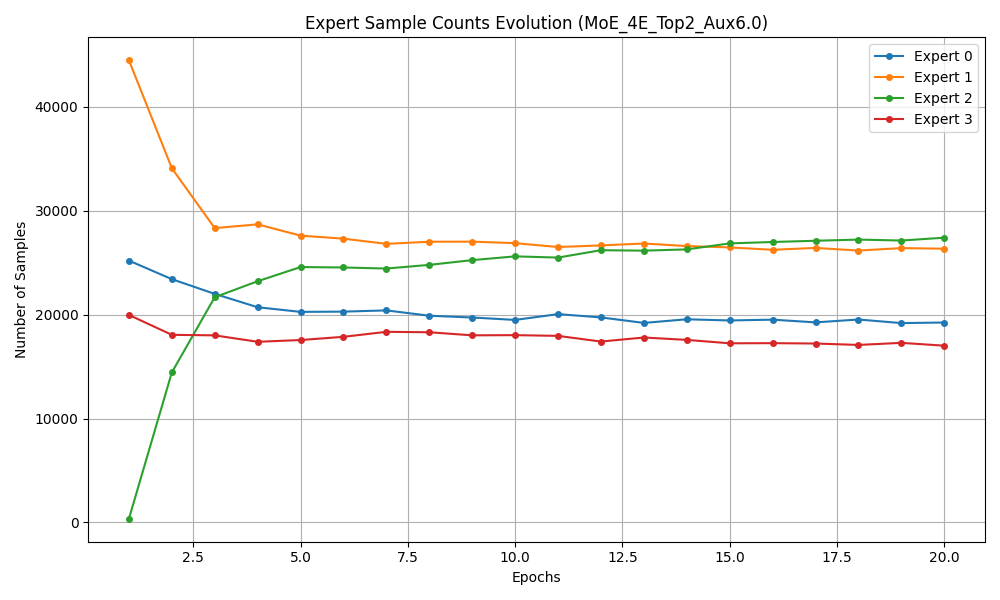

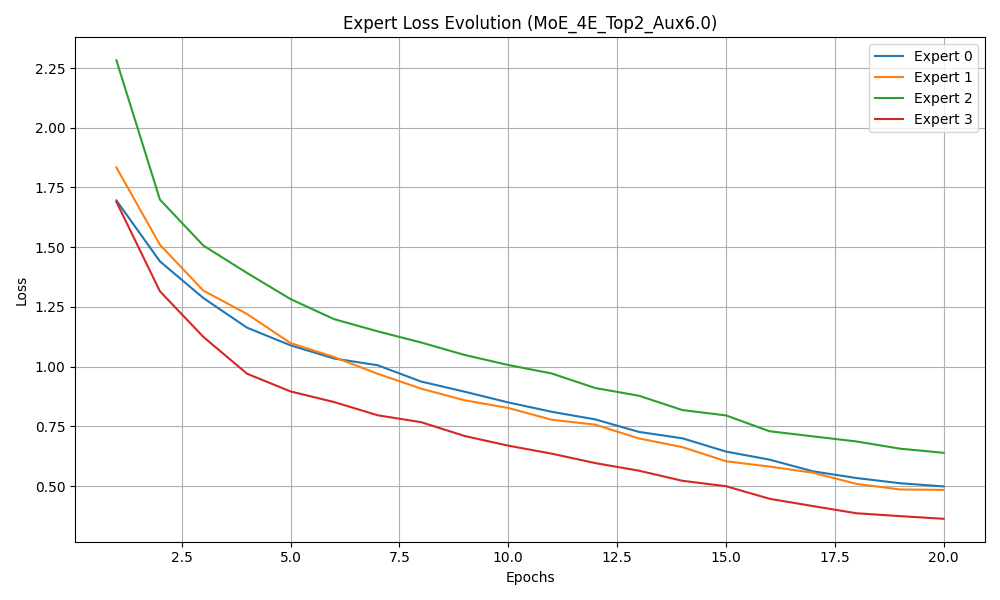


--- Analyzing MoE_8E_Top2_Aux10.0 ---


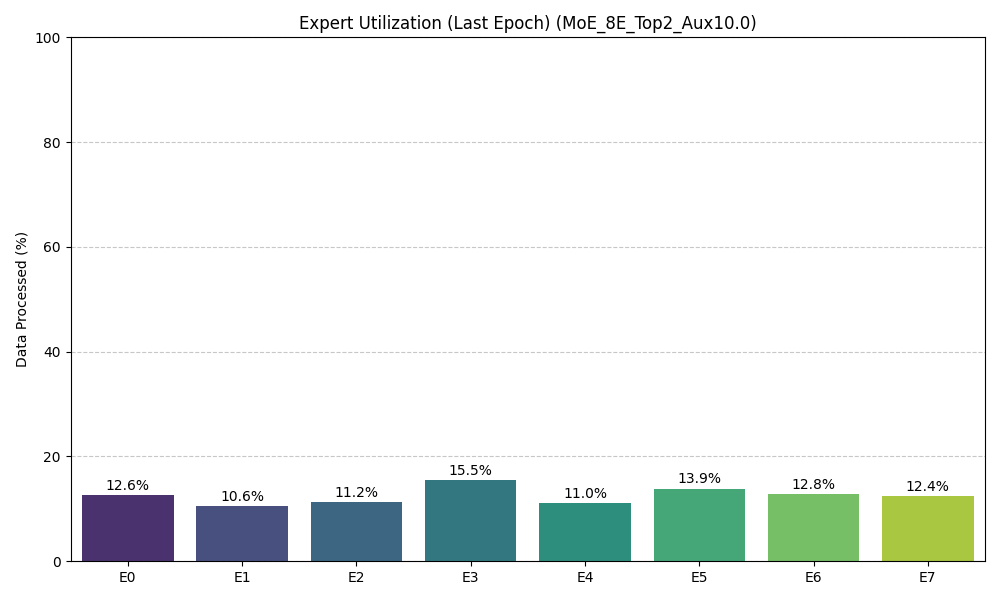

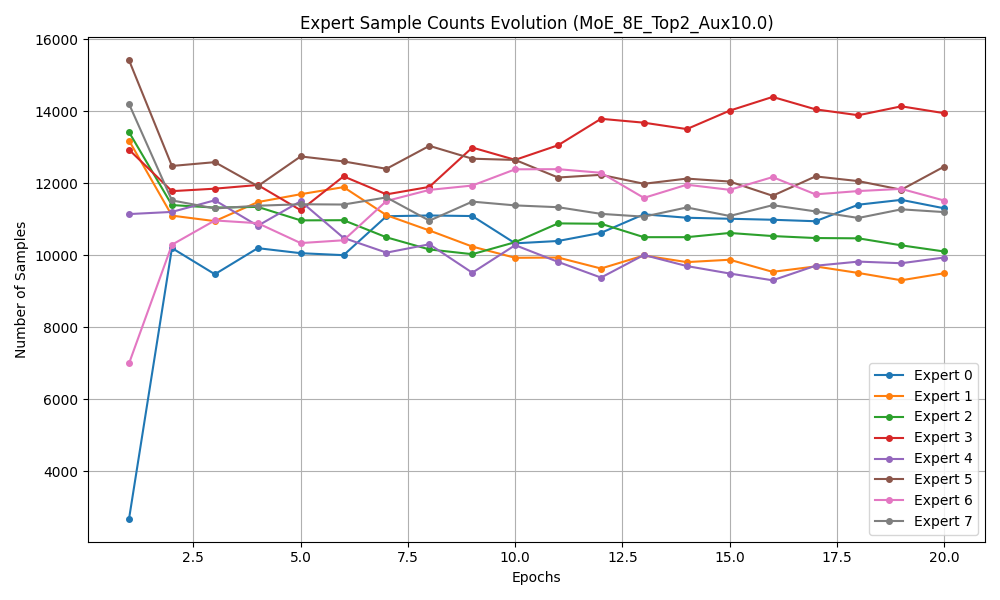

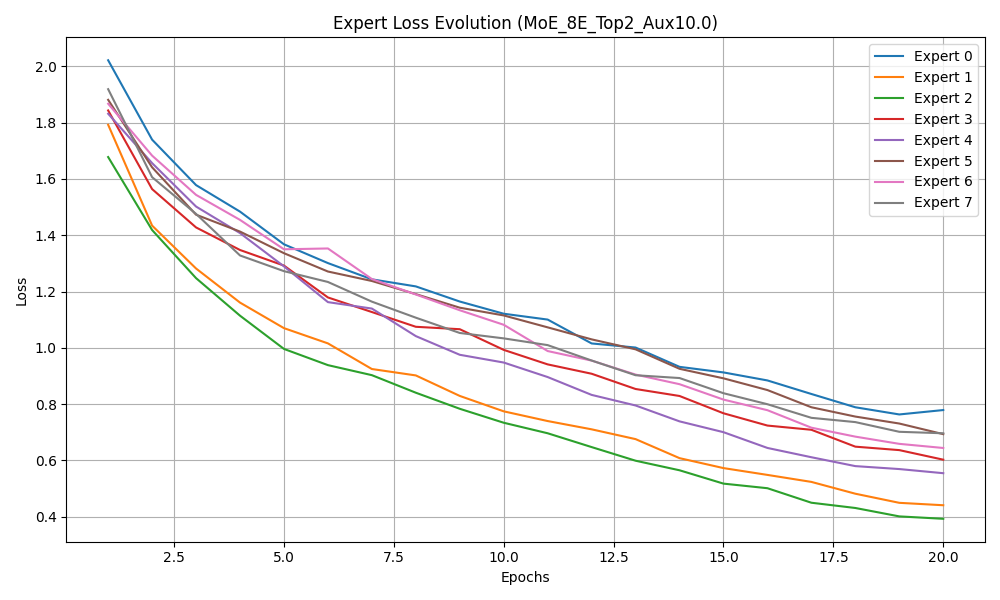

In [6]:
# Analyze each MoE configuration
for name in moe_histories.keys():
    print(f"\n--- Analyzing {name} ---")
    hist = moe_histories[name]
    
    # 1. Expert Usage Histogram (Last Epoch)
    plot_expert_utilization_histogram(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_utilization_histogram{f"({name})".replace(" ", "_").lower()}.png')))
    
    # 1b. Expert Usage Evolution (Stacked Area)
    # plot_expert_utilization(hist, SAVE_DIR) # Generates 'expert_utilization_evolution.png'
    # Rename it to keep unique
    # os.rename(os.path.join(SAVE_DIR, 'expert_utilization_evolution.png'), 
    #           os.path.join(SAVE_DIR, f'expert_utilization_evolution_{name}.png'))
    
    # 2. Expert Counts Evolution (Line Plot)
    plot_expert_counts_evolution(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_counts_evolution{f"({name})".replace(" ", "_").lower()}.png')))

    # 3. Expert Loss Evolution
    plot_expert_loss_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_loss_evolution{f"({name})".replace(" ", "_").lower()}.png')))


# 4. Specialization
Do experts specialize in specific classes (e.g., Expert 0 -> Animals, Expert 1 -> Vehicles)?


--- Specialization: MoE_4E_Top1_Aux0.0 ---


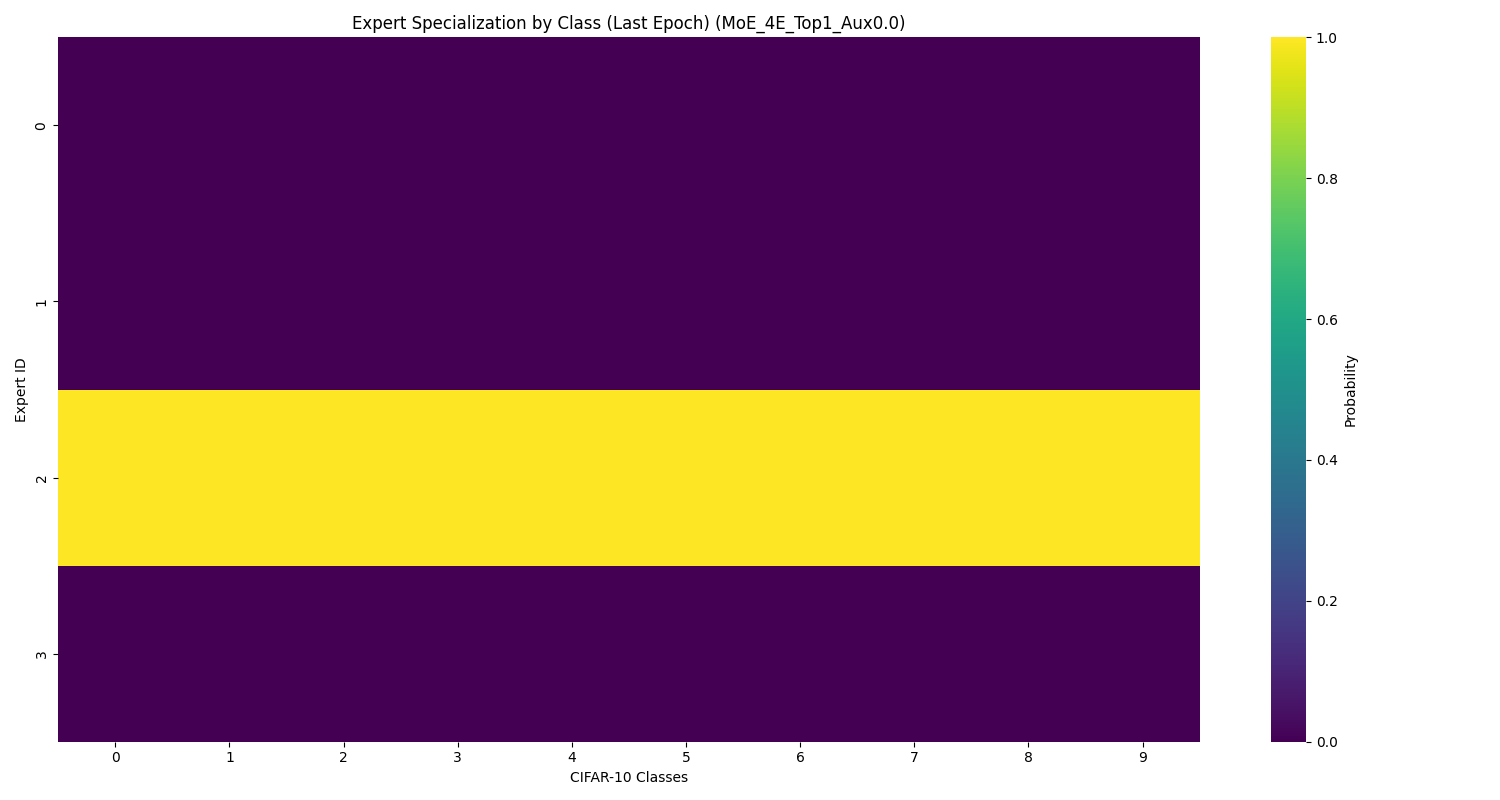


--- Specialization: MoE_4E_Top1_Aux3.0 ---


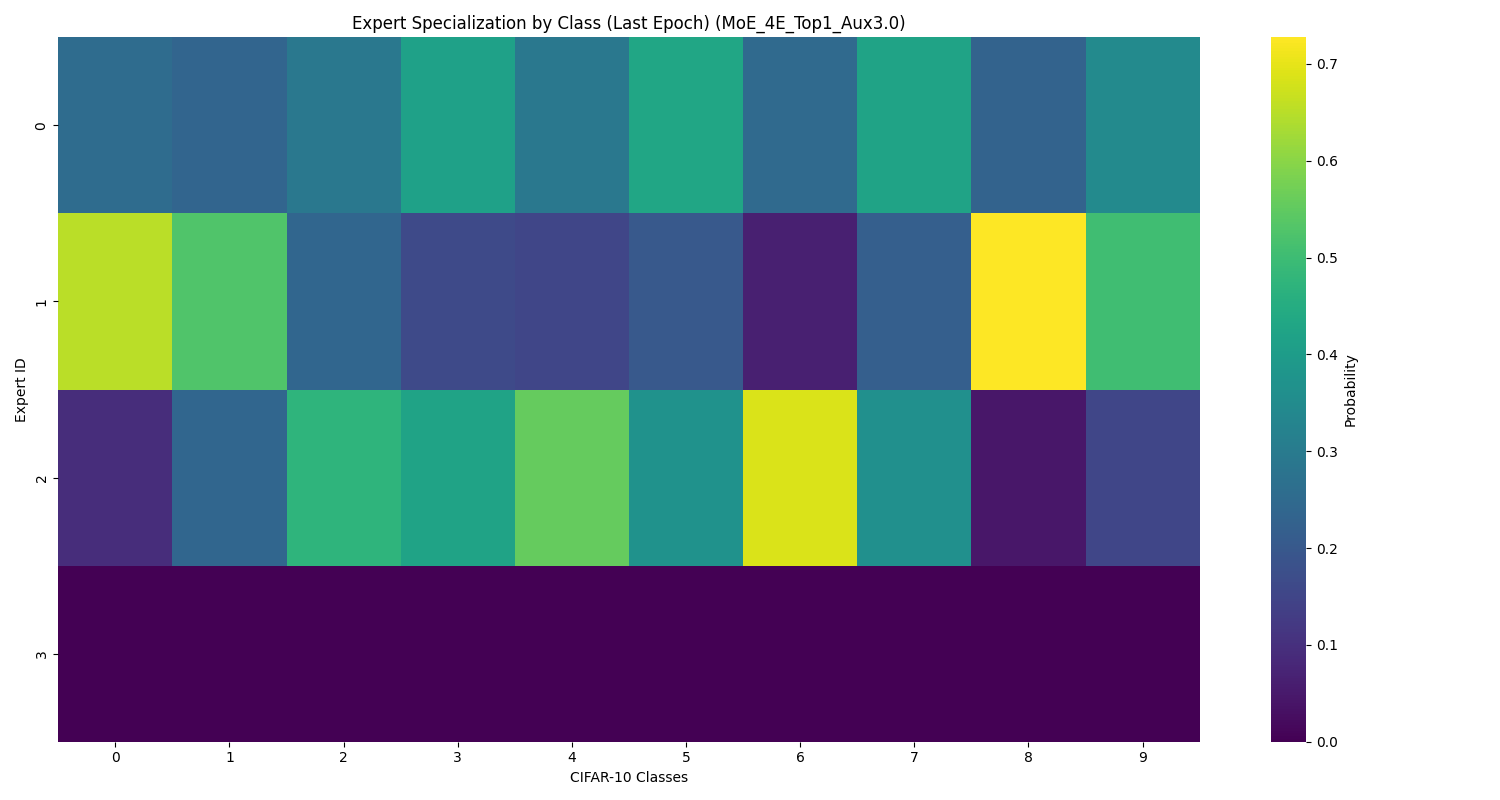


--- Specialization: MoE_4E_Top2_Aux3.0 ---


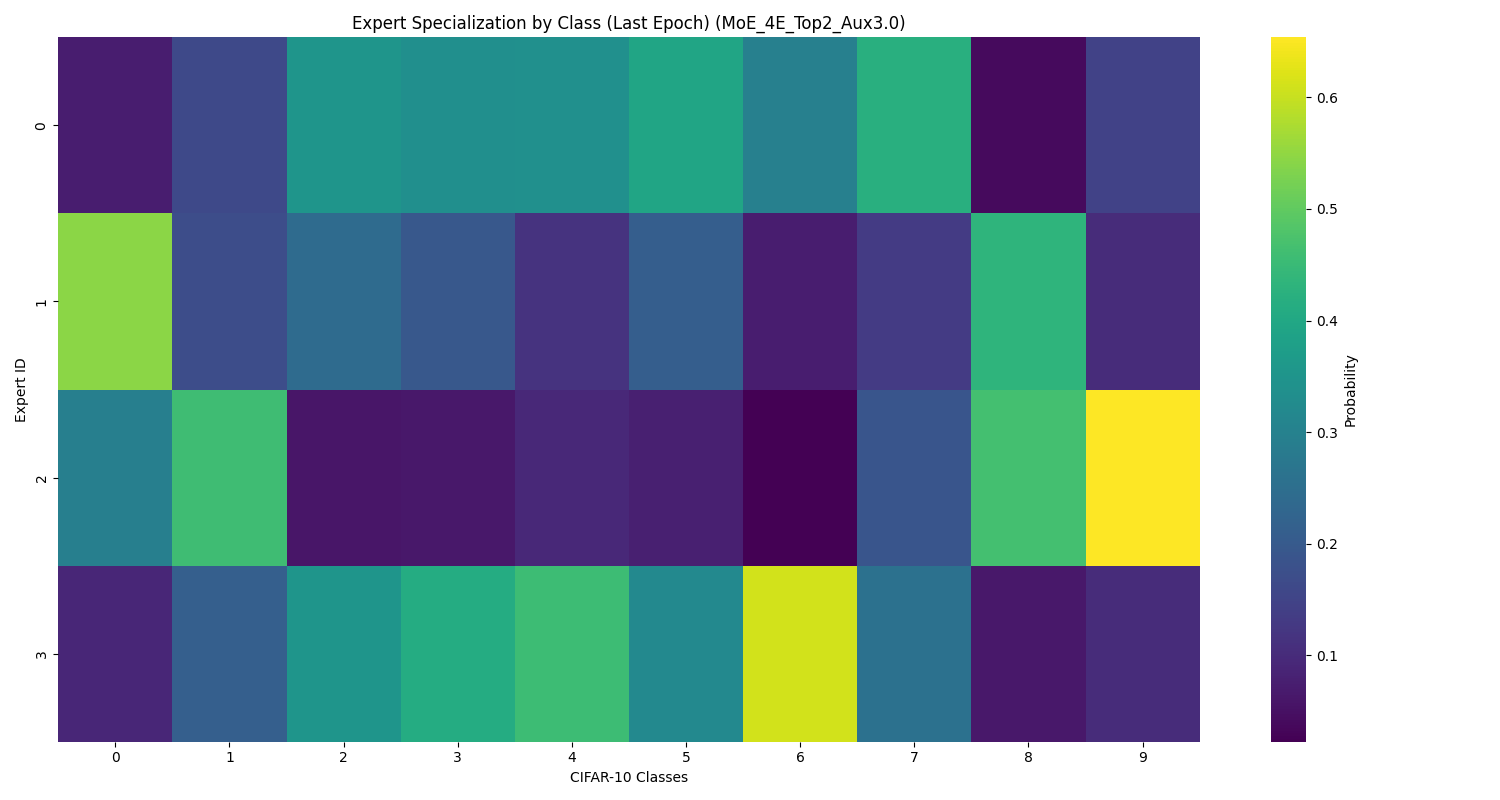


--- Specialization: MoE_4E_Top2_Aux6.0 ---


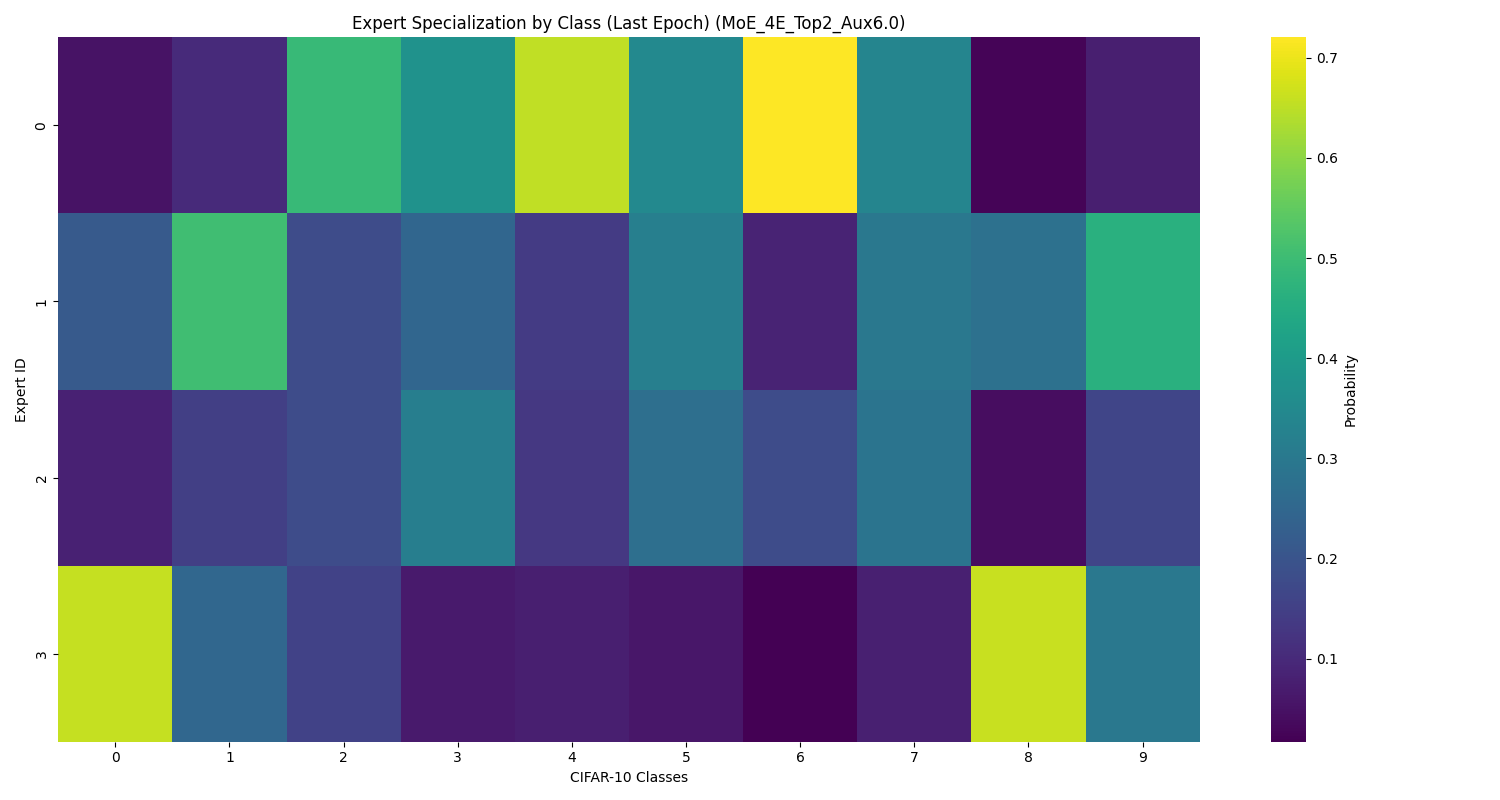


--- Specialization: MoE_8E_Top2_Aux10.0 ---


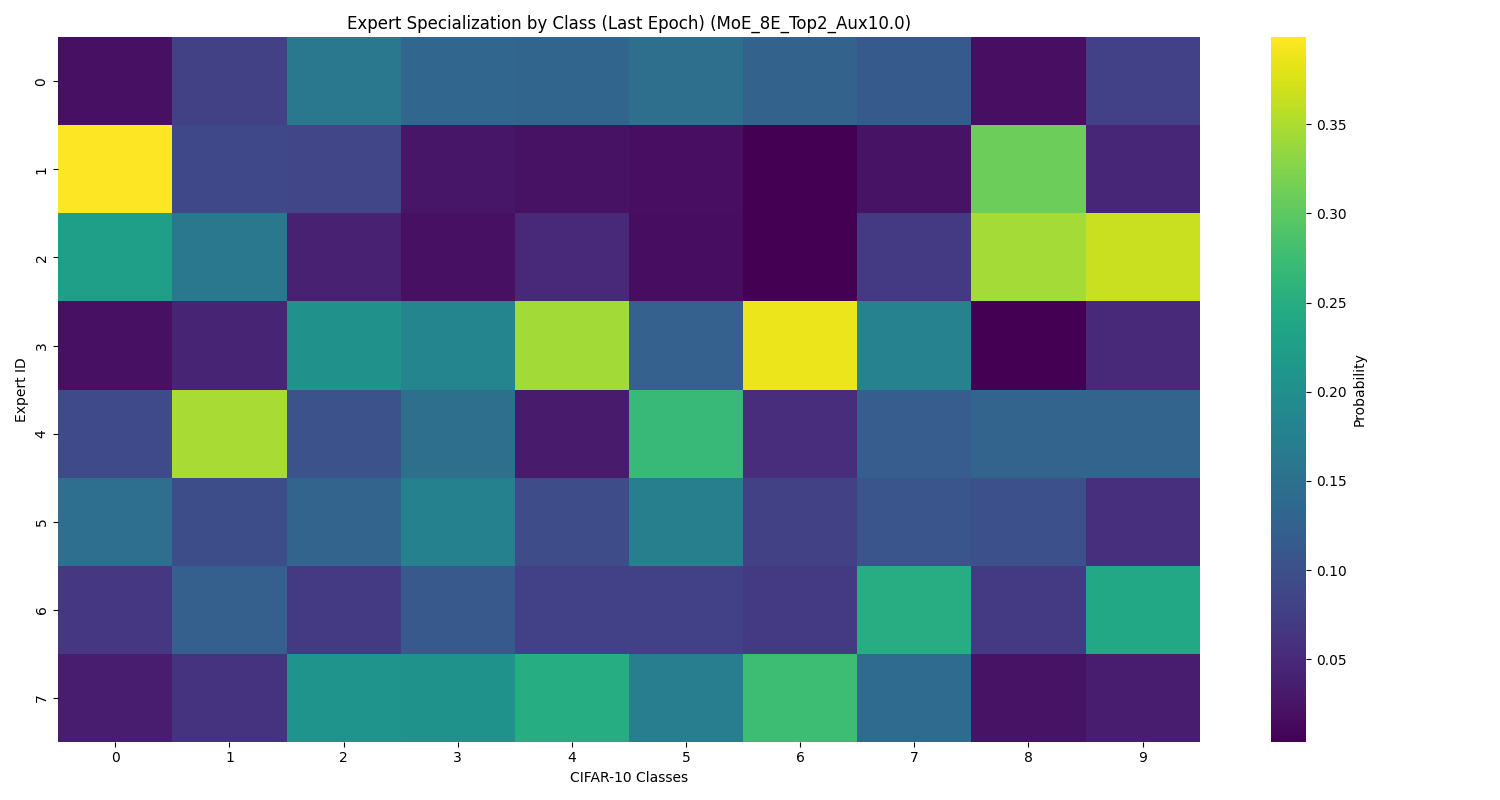

In [7]:
for name in moe_histories.keys():
    print(f"\n--- Specialization: {name} ---")
    hist = moe_histories[name]
    
    plot_expert_heatmap_from_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_specialization_heatmap{f"({name})".replace(" ", "_").lower()}.png')))
